<a href="https://colab.research.google.com/github/salmaaa9/FaceDetectionRecognition/blob/main/OpenCV_Face_Detection_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from google.colab import files

In [2]:
print("Please upload the OpenCV face detector weights file (.pb and .pbtxt files)")
uploaded = files.upload()

Please upload the OpenCV face detector weights file (.pb and .pbtxt files)


Saving opencv_face_detector_uint8.pb to opencv_face_detector_uint8.pb


In [3]:
weights_path = next(iter(uploaded.keys()))
print(weights_path)

opencv_face_detector_uint8.pb


In [4]:
print("Please upload the OpenCV face detector  model architecture file (.pb and .pbtxt files)")
uploaded1 = files.upload()

Please upload the OpenCV face detector  model architecture file (.pb and .pbtxt files)


Saving opencv_face_detector.pbtxt to opencv_face_detector.pbtxt


In [5]:
weights_path = next(iter(uploaded1.keys()))
print(weights_path)

opencv_face_detector.pbtxt


In [6]:
# Get the file paths
pb_files = [filename for filename in uploaded.keys() if filename.endswith('.pb')]
pbtxt_files = [filename for filename in uploaded1.keys() if filename.endswith('.pbtxt')]



In [7]:
# Load the OpenCV face detector model
net = cv2.dnn.readNetFromTensorflow(pb_files[0], pbtxt_files[0])


In [8]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [9]:
# Function to perform face detection on a static photo
def detect_faces(net, frame):
    # Perform face detection
    blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300), [104., 177., 123.], False, False)
    net.setInput(blob)
    detections = net.forward()

    faces = []
    # Process the detections
    for i in range(0, detections.shape[2]):
        # Get the confidence (probability) of the current detection:
        confidence = detections[0, 0, i, 2]
        # Only consider detections if confidence is greater than a fixed minimum confidence:
        if confidence > 0.7:
            # Get the coordinates of the current detection:
            box = detections[0, 0, i, 3:7] * np.array([frame.shape[1], frame.shape[0], frame.shape[1], frame.shape[0]])
            (startX, startY, endX, endY) = box.astype("int")
            width, height = endX - startX, endY - startY
            faces.append((startX, startY, width, height))  # Store the coordinates for cropping

            # Optional: draw the detection and confidence
            text = "{:.3f}%".format(confidence * 100)
            y = startY - 10 if startY - 10 > 10 else startY + 10
            cv2.rectangle(frame, (startX, startY), (endX, endY), (255, 0, 0), 3)
            cv2.putText(frame, text, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)

    return faces, frame  # Return the list of face bounding boxes



In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [11]:
!kaggle datasets download -d hereisburak/pins-face-recognition
import zipfile
with zipfile.ZipFile("pins-face-recognition.zip", 'r') as zip_ref:
    zip_ref.extractall("pins_face_recognition")

Dataset URL: https://www.kaggle.com/datasets/hereisburak/pins-face-recognition
License(s): CC0-1.0
 97% 360M/372M [00:02<00:00, 196MB/s]
100% 372M/372M [00:02<00:00, 181MB/s]


In [12]:
import os
import cv2

# Path to dataset
dataset_path = '/content/pins_face_recognition/105_classes_pins_dataset/'

# Output directory for cropped faces
output_dir = '/content/cropped_faces1/'
os.makedirs(output_dir, exist_ok=True)

# Process each image in the dataset
for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)
    if os.path.isdir(folder_path):
        # Create a corresponding folder in the output directory for each person
        person_output_dir = os.path.join(output_dir, folder)
        os.makedirs(person_output_dir, exist_ok=True)

        for image_name in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_name)
            image = cv2.imread(image_path)

            # Detect faces in the image
            faces,frames = detect_faces(net, image)

            # Check if faces were detected
            if not faces:
                print(f"No faces detected in image {image_name}")
                continue

            # Crop and save each face
            for i, (x, y, w, h) in enumerate(faces):
                face = image[y:y+h, x:x+w]
                cropped_face_name = f"{image_name.split('.')[0]}_cropped_{i}.jpg"
                cropped_face_path = os.path.join(person_output_dir, cropped_face_name)

                # Save the cropped face image
                if cv2.imwrite(cropped_face_path, face):
                    print(f"Saved cropped face to {cropped_face_path}")
                else:
                    print(f"Failed to save cropped face to {cropped_face_path}")

            # # Optional: Display the image with detected faces
            # cv2_imshow(image)
            cv2.waitKey(0)  # Press any key to close the image window

cv2.destroyAllWindows()




Streaming output truncated to the last 5000 lines.
Saved cropped face to /content/cropped_faces1/pins_Shakira Isabel Mebarak/Shakira Isabel Mebarak224_85_cropped_0.jpg
Saved cropped face to /content/cropped_faces1/pins_Sarah Wayne Callies/Sarah Wayne Callies10_2386_cropped_0.jpg
Saved cropped face to /content/cropped_faces1/pins_Sarah Wayne Callies/Sarah Wayne Callies34_2492_cropped_0.jpg
Saved cropped face to /content/cropped_faces1/pins_Sarah Wayne Callies/Sarah Wayne Callies72_2522_cropped_0.jpg
Saved cropped face to /content/cropped_faces1/pins_Sarah Wayne Callies/Sarah Wayne Callies147_2418_cropped_0.jpg
Saved cropped face to /content/cropped_faces1/pins_Sarah Wayne Callies/Sarah Wayne Callies160_2429_cropped_0.jpg
Saved cropped face to /content/cropped_faces1/pins_Sarah Wayne Callies/Sarah Wayne Callies105_2389_cropped_0.jpg
Saved cropped face to /content/cropped_faces1/pins_Sarah Wayne Callies/Sarah Wayne Callies142_2417_cropped_0.jpg
Saved cropped face to /content/cropped_faces

In [ ]:
import pickle
# Assuming you want to save the dictionary to a file in your Google Drive
with open('/content/drive/MyDrive/cropped_faces1.pkl', 'wb') as f:
  pickle.dump(output_dir, f)

<IPython.core.display.Javascript object>

Saved to photo.jpg


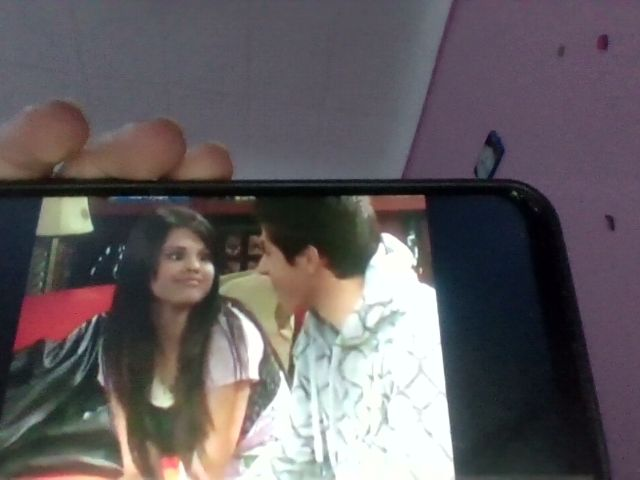

In [ ]:
import cv2
import numpy as np
from IPython.display import Image
from PIL import Image as PIL_Image
from io import BytesIO

try:
    # Capture the photo
    filename = take_photo()
    print('Saved to {}'.format(filename))

    # Load the image using PIL
    img_pil = PIL_Image.open(filename)

    # Convert PIL Image to NumPy array
    img_np = np.array(img_pil)

    # Show the image which was just taken.
    display(Image(filename))

except Exception as err:
    # Errors will be thrown if the user does not have a webcam or if they do not
    # grant the page permission to access it.
    print(str(err))


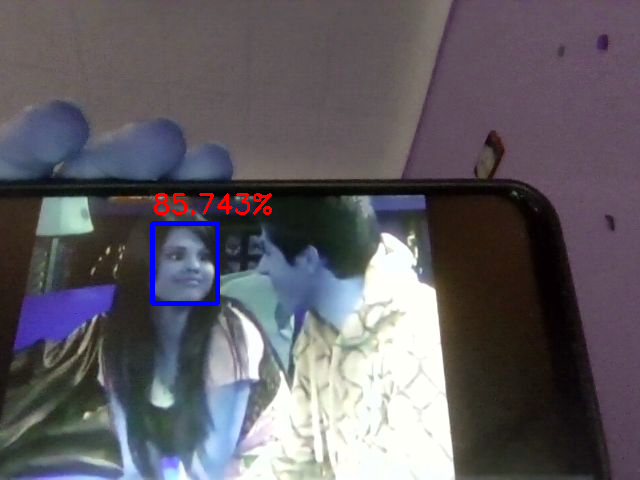

In [ ]:
# Detect faces and get the modified image
faces, img_with_boxes = detect_faces(net, img_np)

# Display the image with rectangles
cv2_imshow(img_with_boxes)

In [14]:
pip install tensorflow opencv-python-headless numpy


In [27]:
from google.colab import files

# Replace 'your_file.txt' with your file's name
file_path = '/content/cropped_faces1'
files.download(file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
import os

def count_classes(folder_path):
    """Counts the number of classes (subdirectories) in a given folder.

    Args:
        folder_path (str): Path to the folder containing the classes.

    Returns:
        int: Number of classes.
    """

    class_dirs = os.listdir(folder_path)
    num_classes = len(class_dirs)
    return num_classes

# Replace 'cropped_data' with the actual path to your folder
folder_path = "/content/cropped_faces1"
num_classes = count_classes(folder_path)

print("Number of classes:", num_classes)

Number of classes: 105


In [23]:
def find_folders_with_one_file(base_dir):
    """Finds folders containing only one file."""
    single_file_folders = []
    for root, dirs, files in os.walk(base_dir):
        if len(files) == 1:
            single_file_folders.append(root)

    return single_file_folders

# Check train and validation directories
single_file_folders = find_folders_with_one_file(folder_path)
print("Folders with only one file:", single_file_folders)


Folders with only one file: []


In [24]:
import os
import shutil
from sklearn.model_selection import train_test_split

def load_data(data_dir):
    """Loads image paths and labels from a given directory."""
    image_paths = []
    labels = []

    for class_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_name)
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            image_paths.append(image_path)
            labels.append(class_name)

    return image_paths, labels

def create_folders(base_dir, class_names):
    """Creates the necessary folders for train and validation sets."""
    train_dir = os.path.join(base_dir, 'train')
    val_dir = os.path.join(base_dir, 'val')

    # Create train and validation directories
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    for class_name in class_names:
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

    return train_dir, val_dir

def move_images(image_paths, labels, X_train, X_val, train_dir, val_dir):
    """Moves the images to the respective directories."""
    # Convert X_train and X_val to sets for faster lookup
    train_set = set(X_train)
    val_set = set(X_val)

    for img_path, label in zip(image_paths, labels):
        if img_path in train_set:
            dest_dir = os.path.join(train_dir, label)
        else:
            dest_dir = os.path.join(val_dir, label)

        shutil.copy(img_path, dest_dir)

# Load image paths and labels
image_paths, labels = load_data(folder_path)  # Replace with your actual dataset folder path

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(image_paths, labels, test_size=0.2, random_state=42, stratify=labels)

# Create train and validation folders
train_dir, val_dir = create_folders('your_destination_folder_path', set(labels))  # Replace with your desired base destination folder

# Move images to respective train and validation folders
move_images(image_paths, labels, X_train, X_val, train_dir, val_dir)

print("Train and validation folders created and images moved.")



Train and validation folders created and images moved.


In [25]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set up paths for the dataset
train_data_dir = '/content/your_destination_folder_path/train'  # Adjust based on your dataset structure
val_data_dir = '/content/your_destination_folder_path/val'

# Create data generators
train_datagen = ImageDataGenerator(rescale=1.0/255.0, rotation_range=20, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')
val_generator = val_datagen.flow_from_directory(val_data_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')



Found 13984 images belonging to 105 classes.
Found 3496 images belonging to 105 classes.


In [26]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top for fine-tuning
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)  # Adjust output to match classes

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])



In [ ]:
# Train the model
history = model.fit(train_generator, epochs=10, validation_data=val_generator)

# Save the model
model.save('/content/face_recognition_model.h5')

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  4/437 ━━━━━━━━━━━━━━━━━━━━ 2:34:51 21s/step - accuracy: 0.0000e+00 - loss: 5.0102

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Load the saved model
model = tf.keras.models.load_model('/content/face_recognition_model.h5')

def get_face_embedding(face_image):
    """Extract the feature embedding for a single face."""
    face_image = tf.image.resize(face_image, (224, 224)) / 255.0
    face_image = tf.expand_dims(face_image, axis=0)  # Add batch dimension
    return model.predict(face_image)

def recognize_face(face_embedding, known_embeddings, threshold=0.5):
    """Recognize face based on cosine similarity."""
    similarities = cosine_similarity([face_embedding], known_embeddings)
    max_similarity = max(similarities[0])

    if max_similarity < threshold:
        return "Not Identified"
    else:
        return np.argmax(similarities)  # return the recognized class index

# Example: Test with a new face image
# Load a new face image (adjust path as needed)
face_image = tf.keras.preprocessing.image.load_img('/path/to/new_face.jpg', target_size=(224, 224))
face_image = tf.keras.preprocessing.image.img_to_array(face_image)
face_embedding = get_face_embedding(face_image)
result = recognize_face(face_embedding, known_embeddings)
print("Recognition result:", result)
